# Basic overview of OA market

In [7]:
import json
import os
import datetime
import numpy as np
import pandas as pd
import pymongo

In [8]:
# get all paper published by SAGE
client = pymongo.MongoClient()
db = client['unpaywall']
coll = db['snapshot']

In [9]:
%%time
from config import Config
filepath = os.path.join(Config.data_dir,'market_totals_dataframe.csv')
if not os.path.exists(filepath):

    oa_types = ['gold','hybrid','bronze','green','closed']
    years = list(range(2010,2021))
    rows = list()
    for year in years:
        for oa_type in oa_types:
            # use 'count_documents' for actual counts, but note that it
            # is actually slower than iterating over the snapshot file.
            cnt = coll.count_documents({'year':year,
                                       'genre':'journal-article',
                                       'oa_status':oa_type})
            row = {'year':year,
                  'oa_type':oa_type,
                  'count':cnt}
            rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(filepath, index=False)
else:
    df = pd.read_csv(filepath)
df.shape

Wall time: 2 ms


(55, 3)

In [10]:
df.pivot(index='year',columns='oa_type', values='count').T
# df.sort_values(2020, ascending = False)

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
oa_type,,,,,,,,,,,
bronze,296645,321691,359286,381591,395864,424510,470759,467591,448402,442701,419931
closed,1714111,1568321,1617331,1691293,1708246,1680385,1700838,1688781,1771144,1852472,2044750
gold,201913,253566,332105,406689,510101,642875,762204,941684,1144714,1421579,1606348
green,240429,254274,269579,291528,295180,290933,305073,312425,307924,259591,171779
hybrid,70063,87193,103746,123807,143344,161752,189544,201624,202670,215953,265987


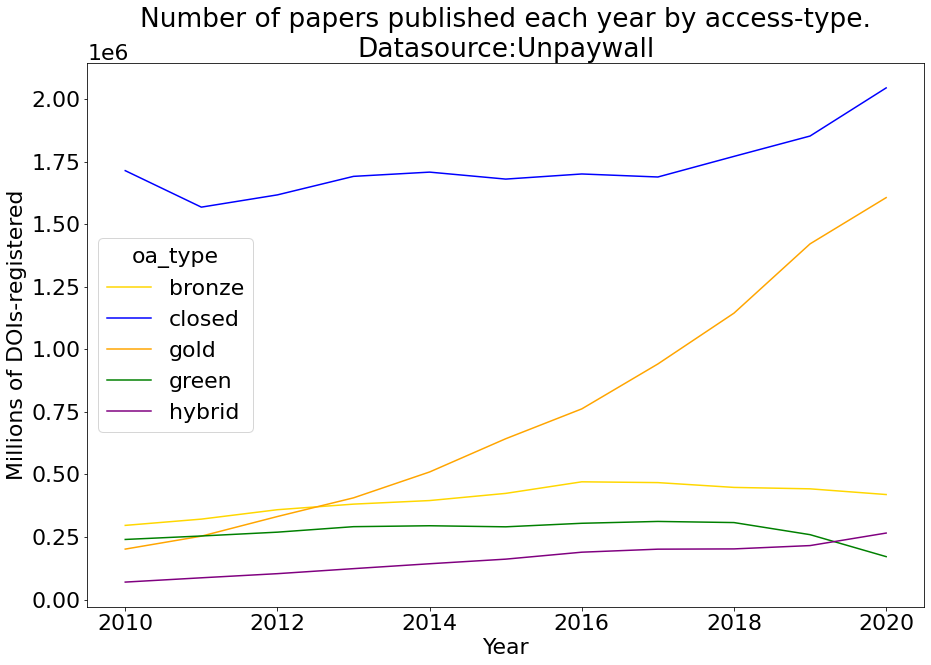

In [11]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(figsize = (15,10))
df.pivot(index='year',columns='oa_type', values='count').plot(
    color = ['gold','blue','orange','green','purple',],
    ax=ax)
ax.set_title('Number of papers published each year by access-type.\nDatasource:Unpaywall')
ax.set_ylabel('Millions of DOIs-registered')
ax.set_xlabel('Year')
plt.rcParams.update({'font.size': 22})
fig_filename = 'market_overview.png'
fig_path = os.path.join(Config.images_dir,fig_filename)
plt.savefig(fig_path)

# Key points
- Long term growth in Gold OA
- Recent rapid growth in Hybrid (likely due to transformative agreements)

## Important point about Green/Bronze trends (and the effect on subscription trend)
- Note that it _appears_ that Green and Bronze are in decline and that subscriptions are growing. It is more likely that the drop in Green is simply caused by embargoes (or other delays in posting articles to repositories). 
- Keep in mind that _all subscription content is just content that isn't Green/Bronze yet_. 
- Green also includes 'submittedVersion', which isn't generally accepted as a definition of Green. This may need parsed out, but it may also be impossible. At what point does an arXiv preprint, which receives no edits in peer-review, become an 'acceptedVersion'? Is unpaywall able to label the versions accurately?
- The definition of Bronze isn't completely clear. Does this include:
  - freebies (temporary access). In which case, do the free coronavirus papers from 2020 become subscription again after some time?
  - articles made free-to-access permanently due to some business model (e.g. all articles become free-to-read after some embargo in a subscription journal). 

## As a percentage

In [16]:
pc = df.pivot(index='year',columns='oa_type', values='count').T / df.pivot(index='year',columns='oa_type', values='count').T.sum()
def percent_it(x):
    """
    Simple function to turn a proportion into a percentage
    """
    return round(100*x,2)
    
pc = pc.apply(percent_it)
pc = pc.sort_values(2020, ascending = False)
pc

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
oa_type,,,,,,,,,,,
closed,67.94,63.11,60.30,58.42,55.96,52.50,49.61,46.75,45.71,44.19,45.35
gold,8.00,10.20,12.38,14.05,16.71,20.09,22.23,26.07,29.54,33.91,35.63
bronze,11.76,12.95,13.40,13.18,12.97,13.26,13.73,12.95,11.57,10.56,9.31
hybrid,2.78,3.51,3.87,4.28,4.70,5.05,5.53,5.58,5.23,5.15,5.90
green,9.53,10.23,10.05,10.07,9.67,9.09,8.90,8.65,7.95,6.19,3.81
